## This study follows the deployment framework of [1] and uses the Lycos-IDS2017 dataset of [2]

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, make_scorer, f1_score, roc_auc_score, roc_curve, auc, classification_report, confusion_matrix
import seaborn as sns
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [2]:
path = os.getcwd()

In [3]:
benign = pd.read_csv(f'{path}/data/Monday-WorkingHours.pcap_lycos.csv')

In [4]:
benign.head()

,flow_id,src_addr,src_port,dst_addr,dst_port,ip_prot,timestamp,flow_duration,down_up_ratio,pkt_len_max,pkt_len_min,pkt_len_mean,pkt_len_var,pkt_len_std,bytes_per_s,pkt_per_s,fwd_pkt_per_s,bwd_pkt_per_s,fwd_pkt_cnt,fwd_pkt_len_tot,fwd_pkt_len_max,fwd_pkt_len_min,fwd_pkt_len_mean,fwd_pkt_len_std,fwd_pkt_hdr_len_tot,fwd_pkt_hdr_len_min,fwd_non_empty_pkt_cnt,bwd_pkt_cnt,bwd_pkt_len_tot,bwd_pkt_len_max,bwd_pkt_len_min,bwd_pkt_len_mean,bwd_pkt_len_std,bwd_pkt_hdr_len_tot,bwd_pkt_hdr_len_min,bwd_non_empty_pkt_cnt,iat_max,iat_min,iat_mean,iat_std,fwd_iat_tot,fwd_iat_max,fwd_iat_min,fwd_iat_mean,fwd_iat_std,bwd_iat_tot,bwd_iat_max,bwd_iat_min,bwd_iat_mean,bwd_iat_std,active_max,active_min,active_mean,active_std,idle_max,idle_min,idle_mean,idle_std,flag_SYN,flag_fin,flag_rst,flag_ack,flag_psh,fwd_flag_psh,bwd_flag_psh,flag_urg,fwd_flag_urg,bwd_flag_urg,flag_cwr,flag_ece,fwd_bulk_bytes_mean,fwd_bulk_pkt_mean,fwd_bulk_rate_mean,bwd_bulk_bytes_mean,bwd_bulk_pkt_mean,bwd_bulk_rate_mean,fwd_subflow_bytes_mean,fwd_subflow_pkt_mean,bwd_subflow_bytes_mean,bwd_subflow_pkt_mean,fwd_tcp_init_win_bytes,bwd_tcp_init_win_bytes,label
0,224.0.0.22-192.168.10.9-0-0-2,224.0.0.22,0,192.168.10.9,0,2,1499082997567312,84524,0.000000,8.0,8.0,8.00,0.000000,0.000000,3.785907e+02,47.323837,0.000000,47.323837,0,0,0.0,0.0,0.000000,0.000000,0,0,0,4,32,8.0,8.0,8.000000,0.000000,32,8,4,83220.0,160.0,2.817467e+04,4.767320e+04,0,0.0,0.0,0.000000e+00,0.000000e+00,84524,83220.0,160.0,2.817467e+04,4.767320e+04,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.000000e+00,32.000000,4.000000,378.590696,0.0,0.0,32.0,4.0,-1,-1,benign
1,192.168.10.9-224.0.0.252-60372-5355-17,192.168.10.9,60372,224.0.0.252,5355,17,1499082997568863,98644,0.000000,28.0,28.0,28.00,0.000000,0.000000,5.109282e+03,182.474352,182.474352,0.000000,18,504,28.0,28.0,28.000000,0.000000,144,8,18,0,0,0.0,0.0,0.000000,0.000000,0,0,0,98619.0,1.0,5.802588e+03,2.391824e+04,98644,98619.0,1.0,5.802588e+03,2.391824e+04,0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0,0,0,0,0,0,0,0,0,0,0,0,504.0,18.0,5.109282e+03,0.000000,0.000000,0.000000,504.0,18.0,0.0,0.0,-1,-1,benign
2,192.168.10.9-192.168.10.3-137-137-17,192.168.10.9,137,192.168.10.3,137,17,1499082997897192,83068408,1.105263,68.0,50.0,59.15,43.724051,6.612416,5.696510e+01,0.963062,0.457454,0.505607,38,2224,68.0,50.0,58.526316,9.108169,304,8,38,42,2508,62.0,0.0,59.714286,2.949045,336,8,42,50778435.0,1.0,1.051499e+06,5.971943e+06,83068326,50778573.0,1.0,2.245090e+06,8.632611e+06,83068177,50778563.0,1.0,2.026053e+06,8.217163e+06,14874848.0,1502094.0,8188471.0,9.455965e+06,50778435.0,15888498.0,33333466.5,2.467091e+07,0,0,0,0,0,0,0,0,0,0,0,0,408.0,6.0,6.181818e+06,281.333333,4.666667,14842.170052,222.4,3.8,250.8,4.2,-1,-1,benign
3,192.168.10.9-192.168.10.3-63683-53-17,192.168.10.9,63683,192.168.10.3,53,17,1499082997908429,292,1.000000,131.0,81.0,106.00,833.333333,28.867513,1.452055e+06,13698.630137,6849.315068,6849.315068,2,162,81.0,81.0,81.000000,0.000000,16,8,2,2,262,131.0,0.0,131.000000,0.000000,16,8,2,286.0,3.0,9.733333e+01,1.633901e+02,3,3.0,3.0,3.000000e+00,0.000000e+00,3,3.0,3.0,3.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.000000e+00,0.000000,0.000000,0.000000,162.0,2.0,262.0,2.0,-1,-1,benign
4,192.168.10.9-192.168.10.3-63276-53-17,192.168.10.9,63276,192.168.10.3,53,17,1499082997908639,293,1.000000,131.0,81.0,106.00,833.333333,28.867513,1.447099e+06,13651.877133,6825.938567,6825.938567,2,162,81.0,81.0,81.000000,0.000000,16,8,2,2,262,131.0,0.0,131.000000,0.000000,16,8,2,196.0,48.0,9.766667e+01,8.516063e+01,49,49.0,49.0,4.900000e+01,0.000000e+00,48,48.0,48.0,4.800000e+01,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.000000e+00,0.000000,0.000000,0.000000,162.0,2.0,262.0,2.0,-1,-1,benign


In [5]:
benign['label'].unique()

array(['benign'], dtype=object)

In [6]:
attack = pd.read_csv(f'{path}/data/Friday-WorkingHours.pcap_lycos.csv')

In [7]:
attack.head()

,flow_id,src_addr,src_port,dst_addr,dst_port,ip_prot,timestamp,flow_duration,down_up_ratio,pkt_len_max,pkt_len_min,pkt_len_mean,pkt_len_var,pkt_len_std,bytes_per_s,pkt_per_s,fwd_pkt_per_s,bwd_pkt_per_s,fwd_pkt_cnt,fwd_pkt_len_tot,fwd_pkt_len_max,fwd_pkt_len_min,fwd_pkt_len_mean,fwd_pkt_len_std,fwd_pkt_hdr_len_tot,fwd_pkt_hdr_len_min,fwd_non_empty_pkt_cnt,bwd_pkt_cnt,bwd_pkt_len_tot,bwd_pkt_len_max,bwd_pkt_len_min,bwd_pkt_len_mean,bwd_pkt_len_std,bwd_pkt_hdr_len_tot,bwd_pkt_hdr_len_min,bwd_non_empty_pkt_cnt,iat_max,iat_min,iat_mean,iat_std,fwd_iat_tot,fwd_iat_max,fwd_iat_min,fwd_iat_mean,fwd_iat_std,bwd_iat_tot,bwd_iat_max,bwd_iat_min,bwd_iat_mean,bwd_iat_std,active_max,active_min,active_mean,active_std,idle_max,idle_min,idle_mean,idle_std,flag_SYN,flag_fin,flag_rst,flag_ack,flag_psh,fwd_flag_psh,bwd_flag_psh,flag_urg,fwd_flag_urg,bwd_flag_urg,flag_cwr,flag_ece,fwd_bulk_bytes_mean,fwd_bulk_pkt_mean,fwd_bulk_rate_mean,bwd_bulk_bytes_mean,bwd_bulk_pkt_mean,bwd_bulk_rate_mean,fwd_subflow_bytes_mean,fwd_subflow_pkt_mean,bwd_subflow_bytes_mean,bwd_subflow_pkt_mean,fwd_tcp_init_win_bytes,bwd_tcp_init_win_bytes,label
0,192.168.10.3-192.168.10.50-3268-56108-6,192.168.10.3,3268,192.168.10.50,56108,6,1499428790315195,112740690,2.0,403.0,0.0,158.333333,31450.099291,177.341758,67.411331,0.425756,0.141919,0.283837,16,1152,72.0,0.0,72.0,0.000000,512,32,16,32,6448,403.0,0.0,201.5,204.724205,1024,32,16,16399772.0,3.0,2.398738e+06,5.798698e+06,112740348,16400110.0,3.0,7.516023e+06,8.323385e+06,112740690,16399772.0,3.0,3.636796e+06,6.848761e+06,380.0,343.0,3.594286e+02,1.199802e+01,16399772.0,15375229.0,1.610540e+07,4.988048e+05,0,0,0,48,32,16,16,0,0,0,0,0,0.0,0.0,0.000000,0.0,0.0,0.0,144.000000,2.000000,806.000000,4.000000,2078,377,benign
1,192.168.10.50-192.168.10.3-42144-389-6,192.168.10.50,42144,192.168.10.3,389,6,1499428790316273,112740560,0.5,403.0,0.0,239.666667,30619.460993,174.984174,102.039585,0.425756,0.283838,0.141919,32,6448,403.0,0.0,201.5,204.724205,1024,32,16,16,5056,316.0,0.0,316.0,0.000000,512,32,16,16399782.0,2.0,2.398735e+06,5.798710e+06,112740560,16399782.0,2.0,3.636792e+06,6.848777e+06,112740242,16400110.0,4.0,7.516016e+06,8.323376e+06,330.0,285.0,3.202857e+02,1.574499e+01,16399782.0,15375263.0,1.610543e+07,4.987937e+05,0,0,0,48,32,16,16,0,0,0,0,0,0.0,0.0,0.000000,0.0,0.0,0.0,806.000000,4.000000,632.000000,2.000000,955,2078,benign
2,192.168.10.9-224.0.0.22-0-0-2,192.168.10.9,0,224.0.0.22,0,2,1499428834843793,54760,0.0,8.0,8.0,8.000000,0.000000,0.000000,584.368152,73.046019,73.046019,0.000000,4,32,8.0,8.0,8.0,0.000000,32,8,4,0,0,0.0,0.0,0.0,0.000000,0,0,0,53431.0,108.0,1.825333e+04,3.046984e+04,54760,53431.0,108.0,1.825333e+04,3.046984e+04,0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0,0,0,0,0,0,0,0,0,0,0,0,32.0,4.0,584.368152,0.0,0.0,0.0,32.000000,4.000000,0.000000,0.000000,-1,-1,benign
3,192.168.10.9-224.0.0.252-63210-5355-17,192.168.10.9,63210,224.0.0.252,5355,17,1499428834845380,100126,0.0,28.0,28.0,28.000000,0.000000,0.000000,6152.248167,219.723149,219.723149,0.000000,22,616,28.0,28.0,28.0,0.000000,176,8,22,0,0,0.0,0.0,0.0,0.000000,0,0,0,100055.0,1.0,4.767905e+03,2.183302e+04,100126,100055.0,1.0,4.767905e+03,2.183302e+04,0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0,0,0,0,0,0,0,0,0,0,0,0,616.0,22.0,6152.248167,0.0,0.0,0.0,616.000000,22.000000,0.000000,0.000000,-1,-1,benign
4,192.168.10.9-192.168.10.3-137-137-17,192.168.10.9,137,192.168.10.3,137,17,1499428835164943,93069427,1.0,68.0,50.0,59.000000,46.153846,6.793662,25.357414,0.429787,0.214893,0.214893,20,1180,68.0,50.0,59.0,9.233805,160,8,20,20,1180,62.0,0.0,59.0,3.077935,160,8,20,50763066.0,3.0,2.386396e+06,9.205496e+06,93069292,50763154.0,3.0,4.898384e+06,1.288064e+07,93069201,50763201.0,3.0,4.898379e+06,1.288065e+07,11894792.0,1512212.0,6.703502e+06,7.341593e+06,50763066.0,28899219.0,3.983114e+07,1.546007e+07,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.000000,

In [8]:
attack['label'].unique()

array(['benign', 'bot', 'portscan', 'ddos'], dtype=object)

In [9]:
print(benign.shape, attack.shape)

(367181, 83) (542962, 83)


In [10]:
attack['ip_prot'].unique()

array([  6,   2,  17,   1, 132])

In [11]:
df = pd.concat([benign, attack], ignore_index=True)

In [12]:
df.describe()

,src_port,dst_port,ip_prot,timestamp,flow_duration,down_up_ratio,pkt_len_max,pkt_len_min,pkt_len_mean,pkt_len_var,pkt_len_std,bytes_per_s,pkt_per_s,fwd_pkt_per_s,bwd_pkt_per_s,fwd_pkt_cnt,fwd_pkt_len_tot,fwd_pkt_len_max,fwd_pkt_len_min,fwd_pkt_len_mean,fwd_pkt_len_std,fwd_pkt_hdr_len_tot,fwd_pkt_hdr_len_min,fwd_non_empty_pkt_cnt,bwd_pkt_cnt,bwd_pkt_len_tot,bwd_pkt_len_max,bwd_pkt_len_min,bwd_pkt_len_mean,bwd_pkt_len_std,bwd_pkt_hdr_len_tot,bwd_pkt_hdr_len_min,bwd_non_empty_pkt_cnt,iat_max,iat_min,iat_mean,iat_std,fwd_iat_tot,fwd_iat_max,fwd_iat_min,fwd_iat_mean,fwd_iat_std,bwd_iat_tot,bwd_iat_max,bwd_iat_min,bwd_iat_mean,bwd_iat_std,active_max,active_min,active_mean,active_std,idle_max,idle_min,idle_mean,idle_std,flag_SYN,flag_fin,flag_rst,flag_ack,flag_psh,fwd_flag_psh,bwd_flag_psh,flag_urg,fwd_flag_urg,bwd_flag_urg,flag_cwr,flag_ece,fwd_bulk_bytes_mean,fwd_bulk_pkt_mean,fwd_bulk_rate_mean,bwd_bulk_bytes_mean,bwd_bulk_pkt_mean,bwd_bulk_rate_mean,fwd_subflow_bytes_mean,fwd_subflow_pkt_mean,bwd_subflow_bytes_mean,bwd_subflow_pkt_mean,fwd_tcp_init_win_bytes,bwd_tcp_init_win_bytes
count,910143.000000,910143.000000,910143.000000,9.101430e+05,9.101430e+05,910143.000000,910143.000000,910143.000000,910143.000000,9.101430e+05,910143.000000,9.101430e+05,9.101430e+05,9.101430e+05,9.101430e+05,910143.000000,9.101430e+05,910143.000000,910143.000000,910143.000000,910143.000000,9.101430e+05,910143.000000,910143.000000,910143.000000,9.101430e+05,910143.000000,910143.000000,910143.000000,910143.000000,9.101430e+05,910143.000000,910143.000000,9.101430e+05,9.101430e+05,9.101430e+05,9.101430e+05,9.101430e+05,9.101430e+05,9.101430e+05,9.101430e+05,9.101430e+05,9.101430e+05,9.101430e+05,9.101430e+05,9.101430e+05,9.101430e+05,9.101430e+05,9.101430e+05,9.101430e+05,9.101430e+05,9.101430e+05,9.101430e+05,9.101430e+05,9.101430e+05,910143.000000,910143.000000,910143.000000,910143.000000,910143.000000,910143.000000,910143.000000,910143.0,910143.0,910143.0,910143.000000,910143.000000,910143.000000,910143.000000,9.101430e+05,9.101430e+05,910143.000000,9.101430e+05,9.101430e+05,910143.000000,9.101430e+05,910143.000000,910143.000000,910143.000000
mean,48497.072300,1785.956081,10.983504,1.499306e+15,1.064845e+07,1.020064,1203.564686,19.821624,258.383677,9.461962e+05,425.270083,4.584192e+05,1.729190e+04,9.883412e+03,7.408483e+03,10.214393,5.096379e+02,181.078265,20.010531,48.570956,53.865697,2.315432e+02,18.098475,2.523140,12.066153,1.884295e+04,1166.724926,0.183699,409.058454,476.222075,2.655046e+02,16.019324,10.189815,4.121533e+06,1.327775e+04,7.747941e+05,1.537258e+06,1.028665e+07,3.910494e+06,1.133934e+06,1.796998e+06,1.056499e+06,9.770272e+06,3.508396e+06,1.225582e+06,1.838727e+06,8.677794e+05,1.492522e+05,4.730601e+04,7.049326e+04,4.332305e+04,3.590148e+06,3.287732e+06,3.457236e+06,1.752639e+05,0.892653,0.334620,0.184475,19.958408,2.808529,1.268505,1.540024,0.0,0.0,0.0,0.000303,0.000346,63.005790,0.220747,1.662735e+05,3.176033e+03,1.640468,9.815737e+05,2.355868e+02,6.147324,1.180543e+04,7.256309,9781.037905,9905.152024
std,16019.389174,6949.697537,5.567116,1.720986e+11,2.937059e+07,0.349033,2368.088446,26.185963,441.202009,2.988995e+06,874.838509,3.973949e+06,7.402065e+04,5.218862e+04,3.282414e+04,846.640171,5.530135e+03,472.497485,34.743363,98.062633,149.870568,1.774387e+04,10.758916,7.022064,1123.178585,2.544744e+06,2354.853069,6.389345,722.600479,1083.954252,2.251185e+04,8.478422,1122.723580,1.352763e+07,1.969332e+05,3.265475e+06,5.895447e+06,2.922771e+07,1.349345e+07,9.130145e+06,9.366577e+06,3.818458e+06,2.858336e+07,1.293697e+07,9.390727e+06,9.640322e+06,3.579724e+06,1.024858e+06,5.877584e+05,6.568423e+05,3.852738e+05,1.327193e+07,1.268117e+07,1.288643e+07,2.073656e+06,0.954953,0.471858,0.387872,1969.493359,22.003208,4.635627,19.892254,0.0,0.0,0.0,0.033046,0.025908,1443.019104,1.607064,3.793174e+06,2.963926e+05,107.136710,6.482172e+06,3.062419e+03,718.211055,2.127059e+06,959.466896,15768.941525,15018.367717
min,0.000000,0.000000,1.000000,1.499083e

# Create the port scan dataset for save keeping

In [13]:
# Uncomment following line if you haven't already saved the port scan data set
#df.to_csv('prt_scn_lycosids2017.csv', index=False)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 910143 entries, 0 to 910142
Data columns (total 83 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   flow_id                 910143 non-null  object 
 1   src_addr                910143 non-null  object 
 2   src_port                910143 non-null  int64  
 3   dst_addr                910143 non-null  object 
 4   dst_port                910143 non-null  int64  
 5   ip_prot                 910143 non-null  int64  
 6   timestamp               910143 non-null  int64  
 7   flow_duration           910143 non-null  int64  
 8   down_up_ratio           910143 non-null  float64
 9   pkt_len_max             910143 non-null  float64
 10  pkt_len_min             910143 non-null  float64
 11  pkt_len_mean            910143 non-null  float64
 12  pkt_len_var             910143 non-null  float64
 13  pkt_len_std             910143 non-null  float64
 14  bytes_per_s         

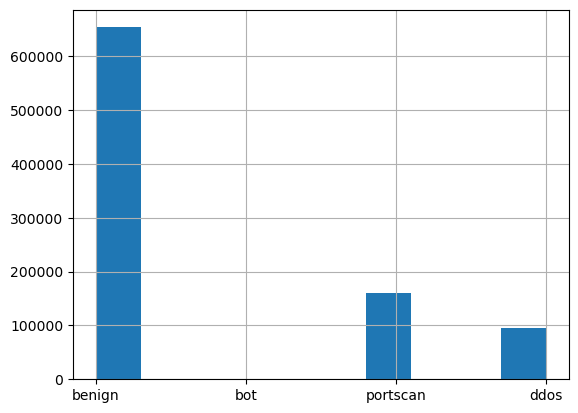

In [15]:
df['label'].hist()
plt.show()

In [16]:
df['label'].value_counts()

label
benign      653619
portscan    160106
ddos         95683
bot            735
Name: count, dtype: int64

In [17]:
df['ip_prot'].unique()

array([  2,  17,   6,   1, 132])

In [18]:
df=df[df['ip_prot']==6] # consider only TCP protocol

### Following features are removed [2]
- flow_id: redundant with other features
- src_addr: not relevant and can be learned
- dst_addr: ditto
- src_port: ditto
- timestamp: avoid learning timeperiods when attacks occur

In [19]:
columns_var=['flow_id', 'src_addr', 'dst_addr', 'src_port', 'timestamp'] # features not applicable to this study
df.drop(columns=columns_var,axis=1,inplace=True)

### Features to keep [2]
- Destinaton port
- IPv4 protocol
- Flow duration
- Downlink/uplink ration
- Maximal lenght among all packets of the flow
- Byte per second rate for this flow
- Packet per second rate for this flow
- Count of forward packets
- Total length of forward packets of the flow
- Maximal length among forward packets of the flow

In [20]:
columns_var=['dst_port', 'ip_prot', 'flow_duration', 'down_up_ratio', 'pkt_len_max', 'bytes_per_s', 'pkt_per_s', 'fwd_pkt_cnt', 'fwd_pkt_len_tot', 'fwd_pkt_len_max', 'label']
df = df[columns_var]

In [21]:
# check features with zero variance (not useful for learning)
features = df.drop(columns = ["label"])
features.var() == 0

dst_port           False
ip_prot            False
flow_duration      False
down_up_ratio      False
pkt_len_max        False
bytes_per_s        False
pkt_per_s          False
fwd_pkt_cnt        False
fwd_pkt_len_tot    False
fwd_pkt_len_max    False
dtype: bool

Looks like we have 3 features, that aren't useful; we need to remove them.

In [22]:
features.isna().sum() # check for missing values

dst_port           0
ip_prot            0
flow_duration      0
down_up_ratio      0
pkt_len_max        0
bytes_per_s        0
pkt_per_s          0
fwd_pkt_cnt        0
fwd_pkt_len_tot    0
fwd_pkt_len_max    0
dtype: int64

In [23]:
features.isnull().sum() # check for nan

dst_port           0
ip_prot            0
flow_duration      0
down_up_ratio      0
pkt_len_max        0
bytes_per_s        0
pkt_per_s          0
fwd_pkt_cnt        0
fwd_pkt_len_tot    0
fwd_pkt_len_max    0
dtype: int64

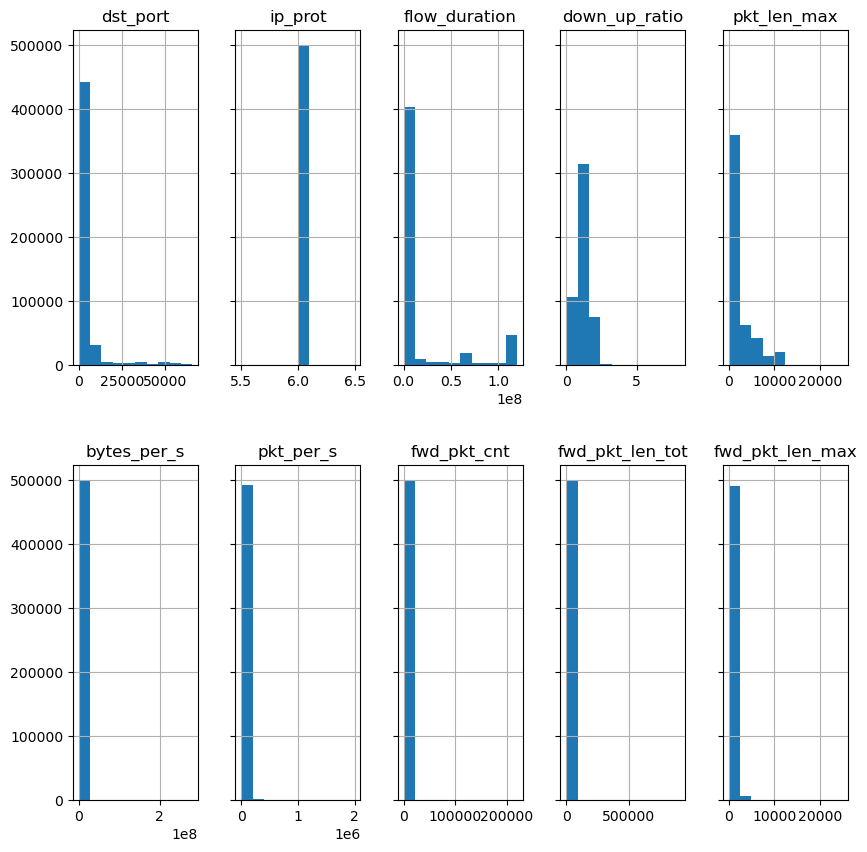

In [24]:
# histograms
df.hist(figsize=(10,10), layout=(2,5),sharex=False, sharey=True, xlabelsize=None, ylabelsize=None)
plt.show()

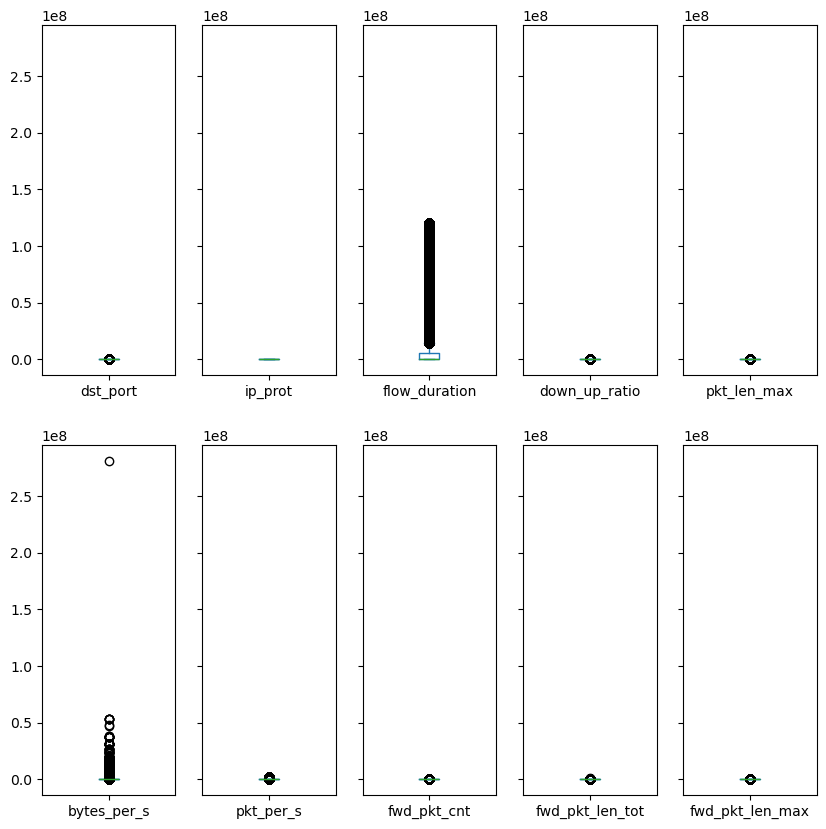

In [25]:
# box and whisker plots
df.plot(kind='box', subplots=True, figsize=(10,10), layout=(2,5), sharex=False, sharey=True,
fontsize=None)
plt.show()

# Bivariate Analysis - Linear correlation (absolute threshold of 0.5)

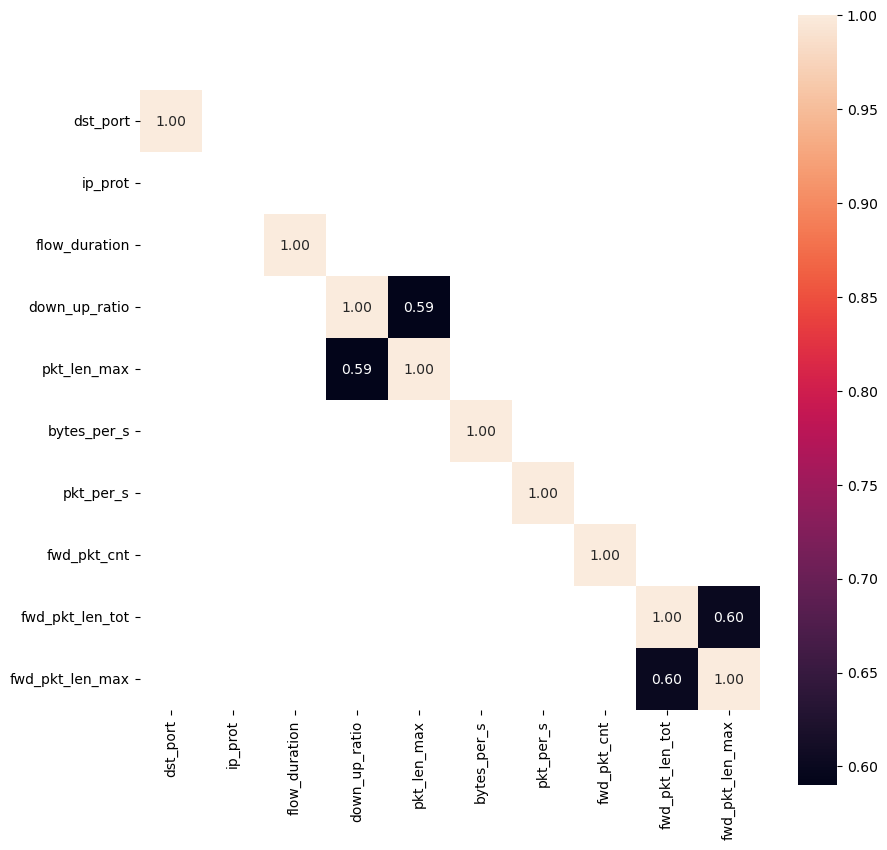

In [26]:
high_corr = features.corr().abs().round(2)
high_corr_var = high_corr[high_corr>0.5]
plt.figure(figsize = (10,10))
sns.heatmap(high_corr_var, fmt='.2f', square=True, xticklabels=high_corr_var.columns, yticklabels=high_corr_var.columns, annot=True);

# Machine Learning - Binary Classification

In [27]:
df.label[df.label == "benign"] = 0 # convert bonafide label to 0
df.label[df.label != 0] = 1 # convert attack labels to 1
df['label'].value_counts()

label
1    256524
0    241551
Name: count, dtype: int64

In [28]:
X = df.drop(columns = ["label"])
y = df.label
#X = X.astype(int) # convert to integers
y = y.astype(int)
print(X.shape, y.shape)

(498075, 10) (498075,)


# Spot checking DT, KNN and SVM models

In [29]:
# Test options and evaluation metric
num_folds = 10
seed = 42
shuffle = True
scoring = 'f1'
validation_size = 0.20

# Spot-Check Algorithms
models = []
models.append(('DT', DecisionTreeClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', SVC()))
models.append(('RF', RandomForestClassifier()))

In [30]:
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y,
test_size=validation_size, random_state=seed)

In [31]:
from sklearn.dummy import DummyClassifier
dummy_majority = DummyClassifier().fit(X_train, Y_train)
dummy_preds = dummy_majority.predict(X_validation)
print("Dummy classifier test score: {:.2f}".format(dummy_majority.score(X_validation, Y_validation)))

Dummy classifier test score: 0.51


In [ ]:
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)

results = []
names = []
for name, model in models:
    cv_results = cross_val_score(model, X_train.values, Y_train.values, cv=kfold, scoring=scoring, n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


DT: 0.999917 (0.000044)
KNN: 0.997867 (0.000116)


In [ ]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [ ]:
# Standardize the dataset
pipelines = []
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()), ('KNN',KNeighborsClassifier())])))
pipelines.append(('ScaledDT', Pipeline([('Scaler', StandardScaler()),('DT', DecisionTreeClassifier())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()),('SVM', SVC())])))
pipelines.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestClassifier())])))

kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)

results = []
names = []
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train.values, Y_train.values, cv=kfold, scoring=scoring, n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

In [ ]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [ ]:
# hyperparameter tuning

algorithms = {
    "DT" : (DecisionTreeClassifier(), {
        "criterion": ("gini", "entropy"), 
        "max_depth": [x for x in range(1,21)],
        "class_weight": (None, "balanced")
    }),
    "KNN" :(KNeighborsClassifier(), {
        "n_neighbors": [x for x in range(1,31)],
        "weights": ["uniform", "distance"]
        #"algorithm": ("ball_tree", "kd_tree", "brute"),
    #    "leaf_size": [x for x in range(28, 34)]
    }),
    #"SVM" :(SVC(random_state=seed, probability=True), [
    #    {"kernel": ["rbf"], "C": [0.1, 1, 10], "gamma": [0.1, 1, 10]},
    #    {"kernel": ["linear"], "C": [0.1, 1, 10]}
    #]),
    "RF" : (RandomForestClassifier(), {
        "n_estimators": (1,100),
        "max_depth": [x for x in range(1,7)],
        "class_weight": (None, "balanced")
    }),
}

# Randomized Search
## Reducing computational expense. The code of [1] is adapted to use RandomizedSearchCV for hyperparameter tuning

In [ ]:
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed) # Train, Test
rskf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed) # Validation
perf = f1_score # can be used roc_auc_score for binary classification

score = {}
results = {}
estimator = {}
for algorithm in algorithms.keys():
    score[algorithm] = []
    results[algorithm] = { 'expected': [], 'predicted': [] }
    estimator[algorithm] = []

for algorithm, (clf, parameters) in algorithms.items():
    print(algorithm)
    for train, test in kf.split(X, y):
        prep = StandardScaler()
        #prep = MinMaxScaler()
        prep.fit(X.iloc[train])
        best = RandomizedSearchCV(clf, parameters, cv=rskf, scoring=make_scorer(perf), n_jobs=-1)
        best.fit(prep.transform(X.iloc[train]), y.iloc[train])
        score[algorithm].append(perf(best.predict(prep.transform(X.iloc[test])), y.iloc[test]))
        results[algorithm]['expected'].extend(y.iloc[test])
        results[algorithm]['predicted'].extend(best.predict_proba(prep.transform(X.iloc[test])).transpose()[1])
    print("Best parameters: {}".format(best.best_params_))
    print("Best cross-validation score: {:.6f}".format(best.best_score_))
    print("Best estimator:\n{}".format(best.best_estimator_))
    estimator[algorithm] = best.best_estimator_
    print("\n")

In [ ]:
# f1-scores
pd.DataFrame.from_dict(score)

In [ ]:
dt=estimator["DT"]
knn=estimator["KNN"]
rf=estimator["RF"]

In [ ]:
pipelines = []
pipelines.append(('KNN', Pipeline([('Scaler', StandardScaler()), ('KNN',knn)])))
pipelines.append(('DT', Pipeline([('Scaler', StandardScaler()),('DT', dt)])))
pipelines.append(('RF', Pipeline([('Scaler', StandardScaler()),('RF', rf)])))

In [ ]:
name = []
for name, model in pipelines:
    model_test = model.fit(X_train.values,Y_train.values).predict(X_validation.values)
    print("Model name: ",name)
    print(classification_report(Y_validation.values, model_test, digits=6, target_names=['benign','attack']))
    print("\n")
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    cm = confusion_matrix(Y_validation.values, model_test)
    ax = sns.heatmap(cm, annot=True, fmt='5g', square=True, xticklabels=['benign','attack'], yticklabels=['benign','attack'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(name)

## ROC/AUC evaluation

In [ ]:
plt.style.use('plot_style.txt')

# ROC/AUC scores for the best set of parameters from the Grid Search above (for each k-fold)
for algorithm in algorithms.keys():
    roc_auc = roc_auc_score(results[algorithm]['expected'], results[algorithm]['predicted'])
    print('AUC(%s) = %.6f' % (algorithm, roc_auc))

In [ ]:
plt.figure()

index = 0
for model_key, result in results.items():
    fpr, tpr, thresholds = roc_curve(result['expected'], result['predicted'])
    AUC = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label="{} (AUC={:.6f})".format(model_key, AUC))
    index = index + 1
    # save ROC data
    #filename = 'data/LAN_'+model_key+'_ROC_data.csv'
    #pd.DataFrame.from_dict(data={ 'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds }).to_csv(filename, index=False)
    
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")

#plt.savefig(os.path.join('images/', 'roc_lan_models.pdf'), dpi=300, bbox_inches="tight")

## Generate the models

### Prepare data - Pre-processing for ML

In [ ]:
prep = StandardScaler()
prep.fit(X)

In [ ]:
from joblib import dump
dump(prep, open('Models/preprocessor.pkl', 'wb'))

### Best estimators from Randomized Search CV

In [ ]:
dt.fit(X,y)
knn.fit(X,y)
rf.fit(X,y)

In [ ]:
dump(dt, open('Models/dt.pkl', 'wb'))
dump(knn, open('Models/knn.pkl', 'wb'))
dump(rf, open('Models/rf.pkl', 'wb'))

# References
>[1] G. De Carvalho Bertoli et al., “An End-to-End Framework for Machine Learning-Based Network Intrusion Detection System,” IEEE Access, vol. 9, pp. 106790–106805, 2021, doi: 10.1109/ACCESS.2021.3101188.\
>[2] A. Rosay, F. Carlier, E. Cheval, and P. Leroux, “From CIC-IDS2017 to LYCOS-IDS2017: A corrected dataset for better performance,” in IEEE/WIC/ACM International Conference on Web Intelligence, ESSENDON VIC Australia: ACM, Dec. 2021, pp. 570–575. doi: 10.1145/3486622.3493973.